In [1]:
import numpy as np
import datetime as dt
import pyproj
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import netCDF4 as nc
% matplotlib inline

# Load rainfall data (1km res) - data courtesy KNMI

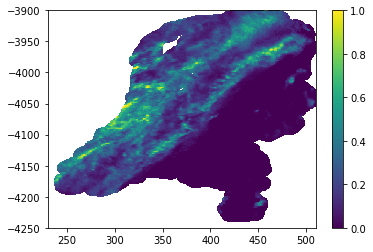

In [2]:
radar_dir = '/media/kriete/TOSHIBA EXT/Data/radar_data/'
year = 2017
month = 12
cur_radar_dir = '%s/%4d/%2d/' % (radar_dir, year, month)
cur_dt = dt.datetime(year, month, 1)

file_name = 'RAD_NL25_RAC_MFBS_EM_5min_201712071500.nc'

# Loading of the dataset & extracting x and y coordinates
ds = nc.Dataset(cur_radar_dir + file_name)
x = np.array(ds['x'])
y = np.array(ds['y'])

# transform  x and y to meshgrid
xgrid, ygrid=np.meshgrid(x, y)

# load data in gridded format and put NaN for invalid values
data = np.array(ds['image1_image_data'])
data[data==65535] = np.nan

# plot the data
fig = plt.figure()
plt.pcolormesh(xgrid, ygrid, data[0], vmin=0, vmax=1)
plt.xlim([230, 510])
plt.ylim([-4250, -3900])
plt.colorbar()

# Define the polygon we want to extract data from (should be the region Den Hague, Rotterdam, Dordrecht)

###### One should note that they have to be in the same projection as the gridded dataset. Hence we need a transformation.

In [3]:
polygon = [
    [52.122645, 4.297280],
    [51.982460, 4.442848],
    [51.943959, 4.745659],
    [51.698716, 4.889673],
    [51.679452, 4.237118],
    [52.029725, 3.814706]
]

###### Now let's transform these coordinates to the target projection. (from WGS84 to PROJ4)

In [4]:
projparams = {
    'proj': 'stere',
    'lat_0': 90,
    'lon_0': 0,
    'lat_ts': 60,
    'a': 6378.137,
    'b': 6356.752,
    'x_0': 0,
    'y_0':0    
}
p1 = pyproj.Proj(projparams)

wgs84 = pyproj.Proj(init='epsg:4326')
new_points = []
for cur_point in polygon:
    cur_lat = cur_point[0]
    cur_lon = cur_point[1]
    new_x, new_y = pyproj.transform(wgs84, p1, cur_lon, cur_lat, radians=False)
    new_points.append([new_x, new_y])
print(np.array(new_points))

[[  306.62246171 -4080.53903753]
 [  318.24916046 -4095.97009122]
 [  340.2619463  -4098.68697689]
 [  352.99270207 -4126.22033686]
 [  306.14190138 -4132.20767539]
 [  272.96111167 -4093.73722386]]


###### Now let's define a function that takes

In [5]:
def get_inside_data(xgrid, ygrid, data, selection_polygon):
    temp_data = data.copy()
    XY = np.dstack((xgrid, ygrid))
    XY_flat = XY.reshape((-1, 2)) # Transform from 2D to 1D

    path = mpltPath.Path(selection_polygon)
    inside_flat = path.contains_points(XY_flat) # 1D mask of points that are inside
    inside = inside_flat.reshape(xgrid.shape) # 2D mask of points that are inside
    
    temp_data[~inside] = np.nan
    return temp_data

###### If you give the gridded x, y and z data as well as the desired polygon coordinates into the function, you'll get the data that's inside of the polygon.

###### Let's call that function to get only the "cropped" data

In [6]:
z = get_inside_data(xgrid, ygrid, data[0], new_points)

###### Let's look at the data

(-4131.5, -4081.5)

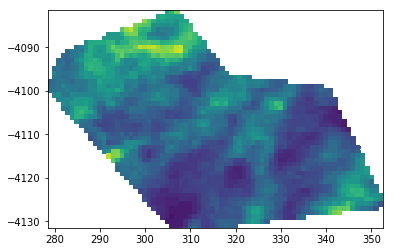

In [7]:
non_nan_idx = ~np.isnan(z)
plt.pcolormesh(xgrid, ygrid, z, vmin=0, vmax=1)
plt.xlim([np.nanmin(xgrid[non_nan_idx]), np.nanmax(xgrid[non_nan_idx])])
plt.ylim([np.nanmin(ygrid[non_nan_idx]), np.nanmax(ygrid[non_nan_idx])])

###### Recall that the returned array will be of the same size as the input grid. I just put NaNs for the values outside of the polygon area.